Import

In [1]:
import pandas as pd
import json
import tensorflow as tf
import matplotlib.pyplot as plt
import mlflow
from mlflow.models import infer_signature

In [2]:
mlflow.set_tracking_uri("sqlite:///mlruns.db")

In [3]:
# ========== Dataset from Drive ==========
# from google.colab import drive
# drive.mount('/data/data')

Classes

In [4]:
import os
for dir, sub_dirs, _ in os.walk("./data"):
    class_names = sub_dirs
    break

json.dump({"classes": class_names}, open("classes.json", "w"))
class_names

['Amanita_Caesarea-Edible',
 'Amanita_Citrina-Edible',
 'Amanita_Pantherina-NotEdible',
 'Boletus_Regius-Edible',
 'Clitocybe_Costata-Edible',
 'Entoloma_Lividum-NotEdible',
 'Gyromitra_Esculenta-NotEdible',
 'Helvella_Crispa-Edible',
 'Hydnum_Rufescens-NotEdible',
 'Hygrophorus_Latitabundus-Edible',
 'Morchella_Deliciosa-Edible',
 'Omphalotus_Olearius-NotEdible',
 'Phallus_Impudicus-NotEdible',
 'Rubroboletus_Satanas-NotEdible',
 'Russula_Cyanoxantha-Edible',
 'Russula_Delica-NotEdible']

In [5]:
# ========== Dataset loading ==============

directory = "./data"
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=class_names,
    color_mode='rgb',
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=120,
    validation_split=0.30,
    subset="training",
    verbose=True)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=class_names,
    color_mode='rgb',
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=120,
    validation_split=0.30,
    subset="validation",
    verbose=True)

# ========== Data Preprocessing ==============
def image_rescaling(img, y):
    img = img * (1./255)
    return img, y

def onehot_encode(img, y):
    y = tf.one_hot(y, 16)
    return img, y


train_dataset = train_dataset.map(image_rescaling)
train_dataset = train_dataset.map(onehot_encode)

validation_dataset = validation_dataset.map(image_rescaling)
validation_dataset = validation_dataset.map(onehot_encode)

# =========== Prefetchig to efficiently load the dataset in memory =========
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(tf.data.AUTOTUNE) 


Found 3017 files belonging to 16 classes.
Using 2112 files for training.
Found 3017 files belonging to 16 classes.
Using 905 files for validation.


img: AxesImage(shape=(128, 128, 3))
target: tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(16,), dtype=float32)


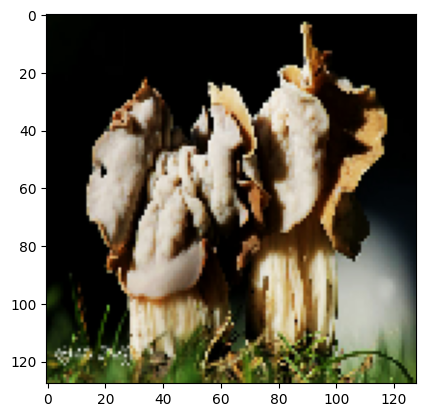

In [6]:
for img, y in train_dataset:
    print("img:", plt.imshow(img[0].numpy()))
    print("target:",y[0])
    break
plt.show()

#### Modelling

In [7]:
def get_model():
    # Input Layer
    image_input = tf.keras.Input(shape=(128, 128, 3), name='image_input')
    # Convolution Layers
    x = tf.keras.layers.Conv2D(16, 3, activation="relu")(image_input)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = tf.keras.layers.Conv2D(32, 3, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = tf.keras.layers.Conv2D(64, 3, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    x = tf.keras.layers.Conv2D(128, 3, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = tf.keras.layers.Conv2D(128, 3, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    ## Fully Connected Layers
    features_output = tf.keras.layers.Flatten()(x)
    x =  tf.keras.layers.Dense(128, activation="relu")(features_output)
    x =  tf.keras.layers.Dense(64, activation="relu")(x)
    output =  tf.keras.layers.Dense(16, name="output")(x)

    # Model Definition
    model = tf.keras.Model(image_input, output, name="mushroom-model")
    model.summary()
    return model

In [8]:
model = get_model()
# ====== Model Compile ======
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.Accuracy()],
              )

# optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)
# sparse_categorical_loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# metrics= tf.keras.metrics.AUC()


Model: "mushroom-model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 16)             │         1,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 319,984 (1.22 MB)

 Trainable params: 319,984 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

#### Training

In [9]:
# for x, y in train_dataset:
#     with tf.GradientTape() as tape:
#         output_logits = model(x, training=True)
#         loss = sparse_categorical_loss()

model.fit(train_dataset, epochs=10)
model.save("mushroom_classifier.keras")

Epoch 1/10


66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 287ms/step - accuracy: 0.0000e+00 - auc: 0.5550 - loss: 2.7502
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 175ms/step - accuracy: 0.0000e+00 - auc: 0.6935 - loss: 2.4811
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 370ms/step - accuracy: 0.0000e+00 - auc: 0.7518 - loss: 2.1916
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 20s 249ms/step - accuracy: 0.0000e+00 - auc: 0.7857 - loss: 2.0004
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 14s 216ms/step - accuracy: 0.0000e+00 - auc: 0.7990 - loss: 1.8450
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 220ms/step - accuracy: 0.0000e+00 - auc: 0.8167 - loss: 1.6912
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 192ms/step - accuracy: 0.0000e+00 - auc: 0.8252 - loss: 1.5386
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 186ms/step - accuracy: 0.0000e+00 - auc: 0.8399 - loss: 1.4223
Epoch 9/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 182ms/step - accuracy: 0.0000e+00 - auc: 0.8487 - loss: 1.2636
Epoch 10/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 183ms/step - accuracy: 

In [10]:
# model evaluation
output_evaluation = model.evaluate(validation_dataset)
output_evaluation

29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 317ms/step - accuracy: 0.0000e+00 - auc: 0.8262 - loss: 1.6200


[1.5347719192504883, 0.830960750579834, 0.0]

Mlflow-Tracking

In [11]:
experiment_name = "mushroom_image_classifier"
try:
    eid = mlflow.create_experiment(name=experiment_name)
except:
    experiment_obj = mlflow.get_experiment_by_name(name=experiment_name)
    eid = experiment_obj.experiment_id
    
with mlflow.start_run(experiment_id=eid) as run:
    mlflow.tensorflow.log_model(model, "mashroom")
    run_id = run.info.run_id
    print("run_id", run_id)
    print("exp_id", eid)

2024/05/27 17:56:04 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
d:\Projects\Mashroop-Image-Classifier\.env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


run_id 0ecc38f16d67447e9be2616b07d41a8e
exp_id 2
